In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from binpan import binpan
from binpan import handlers

from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker

# This book is in progress

In [3]:
!python -V

Python 3.11.2


In [4]:
binpan.__version__

'0.4.11'

In [5]:
sym = binpan.Symbol(symbol='ltcbtc', tick_interval='1m', time_zone='Europe/Madrid', from_redis=True, from_redis_agg_trades=True, from_redis_atomic_trades=True, limit = 1000)

In [6]:
sym.get_atomic_trades()

Requesting atomic trades between 2023-04-04 19:32:37 and 2023-04-05 12:12:38


2023-04-05	 12:12:39     INFO Fetching atomic trades from redis server for LTCBTC
2023-04-05	 12:12:47     INFO Clean atomic 11176 trades found for LTCBTC


,Trade Id,Price,Quantity,Buyer Order Id,Seller Order Id,Date,Timestamp,Buyer was maker,Best price match
LTCBTC Europe/Madrid,,,,,,,,,
2023-04-04 19:32:42.576000+02:00,90070064,0.003307,3.976,1063081361,1063081285,2023-04-04 19:32:42,1680629562576,False,True
2023-04-04 19:32:48.606000+02:00,90070065,0.003308,4.325,1063081421,1063081407,2023-04-04 19:32:48,1680629568606,False,True
2023-04-04 19:32:48.663000+02:00,90070066,0.003308,4.326,1063081422,1063081407,2023-04-04 19:32:48,1680629568663,False,True
2023-04-04 19:32:48.714000+02:00,90070067,0.003308,4.251,1063081424,1063081408,2023-04-04 19:32:48,1680629568714,False,True
2023-04-04 19:32:48.931000+02:00,90070068,0.003309,1.700,1063081429,1063081350,2023-04-04 19:32:48,1680629568931,False,True
...,...,...,...,...,...,...,...,...,...
2023-04-05 10:37:06.610000+02:00,90081235,0.003319,0.420,1063271195,1063270918,2023-04-05 10:37:06,1680683826610,False,True
2023-04-05 10:37:06.610000+02:00,90081236,0.003319,0.150,1063271195,1063270931,2023-04-05 10:37:06,1680683826610,False,True
2023-04-05 10:37:27.473000+02:00,90081237,0.003318,1.361,1063271272,1063271264,2023-04-05 10:37:27,1680683847473,False,True


CBIO: 1m data not available for startTime=1576731600 and endTime=1576818000. The requested range must be within the last 30 days.
Optimum K is 0


C:\Users\hanca\AppData\Local\Temp\ipykernel_1512\739421785.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)


IndexError: list index out of range

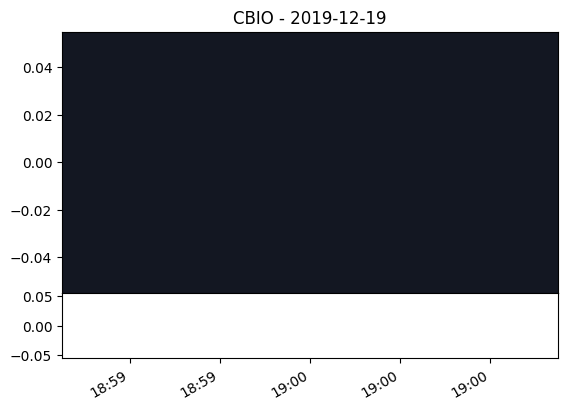

In [7]:
"""
https://www.github.com/judopro
https://www.medium.com/@judopro
"""
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
import pandas
import numpy

from mplfinance.original_flavor import candlestick_ohlc

import yfinance as yf
yf.pdr_override()


def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters


def plot_stock_data(data):
    fig, ax = plt.subplots()
    ax1 = plt.subplot2grid((5,1), (0,0), rowspan=4)
    ax2 = plt.subplot2grid((5,1), (4,0), sharex=ax1)

    ax1.set_title("{} - {}".format(symbol, start))
    ax1.set_facecolor("#131722")
    ax1.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))

    candlestick_ohlc(ax1, data.to_numpy(), width=8, colorup='#77d879', colordown='#db3f3f')

    ax2.bar(data['Time'], data['Volume'], width=30)
    ax2.xaxis.set_major_formatter(mpticker.FuncFormatter(mydate))
    fig.subplots_adjust(hspace=0)
    fig.autofmt_xdate()
    return ax1


def mydate(x,pos):
    try:
        return datetime.datetime.fromtimestamp(x, tz=est).strftime(date_format)
    except IndexError:
        return ''


symbol = "CBIO"
start = "2019-12-19"
end = "2019-12-20"
est = pytz.timezone('US/Eastern')
date_format = "%H:%M"

ticker = yf.Ticker(symbol)
data = ticker.history(period="1d", interval="1m",start=start, end=end, prepost=False, actions=False)
data = data[:60] #30 1M candles

data["Time"] = [d.timestamp() for d in data.index]
data.Time = data.Time.tz_convert(est)
data = data[["Time", "Open", "High", "Low", "Close", "Volume"]]

ax = plot_stock_data(data)

lod, hod = 0, 0

lows = pandas.DataFrame(data=data, index=data.index, columns=["Low"])
highs = pandas.DataFrame(data=data, index=data.index, columns=["High"])

low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = numpy.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = numpy.sort(high_centers, axis=0)

print(data)
print(low_centers)
print(high_centers)

for low in low_centers[:2]:
    ax.axhline(low[0], color='yellow', ls='--')

for high in high_centers[-1:]:
    ax.axhline(high[0], color='orange', ls='--')

plt.show()

In [ ]:
# !pip install -U scikit-learn
stop

In [ ]:
import sys

!{sys.executable} -m pip install yfinance

In [ ]:
!pip install yfinance